In [2]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)


In [3]:
dut.power_on()

DAC initialized to a span from 0 V to 5 V


In [5]:
volt_in = np.arange(0.44, 4.0, 0.1)
volt_out_list = []

adc_raw=[]
for addr_fifo in range(12):
    print(addr_fifo, end='->')
    data = dut.calibrate_adc(volt_in, addr_fifo=addr_fifo )
    volt_out_list.append( [dut.adc2volt(d) for d in data] )
    adc_raw.append(data)

0->1->2->3->4->5->6->7->8->9->10->11->

Text(0, 0.5, 'Quality number')

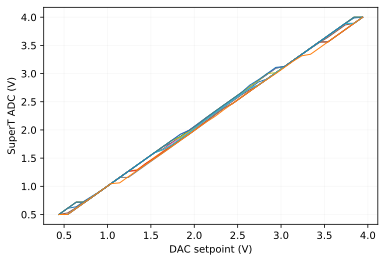

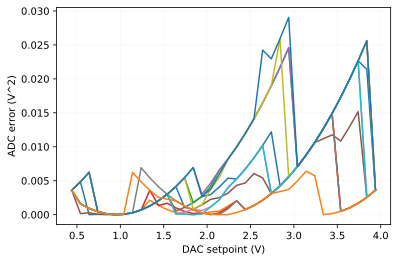

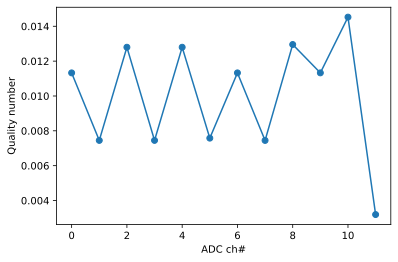

In [6]:
volt_out_list = np.array(volt_out_list)

adc_quality = []

plt.figure(1)
plt.xlabel('DAC setpoint (V)')
plt.ylabel('SuperT ADC (V)')
plt.grid(True, alpha=0.1)

for i, volt_out in enumerate(volt_out_list):
    plt.figure(1)
    plt.plot(volt_in, volt_out, linewidth=1)
    
    voffset=0
    volt_err2 = []
    for vin, vout in zip(volt_in, volt_out):
        volt_err2.append( (vout-vin -voffset)**2 )
    volt_err2 = np.array(volt_err2)
    adc_quality.append( (np.max(volt_err2) - np.min(volt_err2))/2 )
        
    plt.figure(2)
    plt.plot(volt_in, volt_err2)

plt.grid(True, alpha=0.1)
plt.xlabel('DAC setpoint (V)')
plt.ylabel('ADC error (V^2)')
    
plt.figure(3)
plt.plot(range(12), adc_quality, 'o-')
plt.xlabel('ADC ch#')
plt.ylabel('Quality number')

5.00-

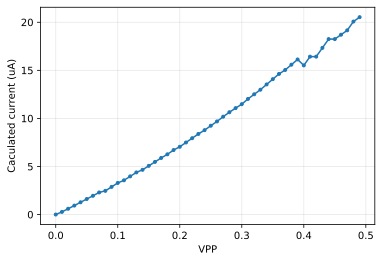

In [7]:
ar=2
r=31
c=0

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=4) )
    volts_set.append(volts)
    
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

5.00-

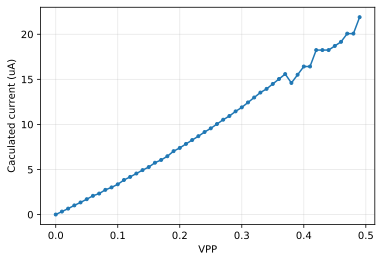

In [38]:
ar=2
r=31
c=0
# ar=1
# r=3
# c=63


Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=-1) )
    volts_set.append(volts)
    
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

In [33]:
Gmap = a0.pic_read_batch(1, gain=2)

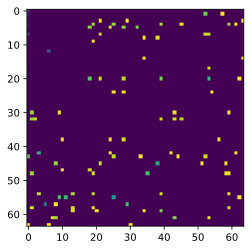

In [34]:
plt.imshow(Gmap)

In [13]:
adc_raw = a0.read_single_int(vread, Vgate, array=ar, row=r, col=c, gain=-1, raw=True)
print(f'{result:013b}')

volt = dut.adc2volt(adc_raw)
print(f'{volt:.4f} V')

gain = adc_raw >> 10
print(f'gain = {gain:d}')

curr = a0.adc2current(adc_raw)
print(f'curr = {curr:.4f} A')

0100010110000
1.1022 V
gain = 2


TypeError: adc2current() missing 1 required positional argument: 'Vref'